<a href="https://colab.research.google.com/github/Camilo-Hernandez/Analisis-computacion-afectiva/blob/main/Miniproyecto1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

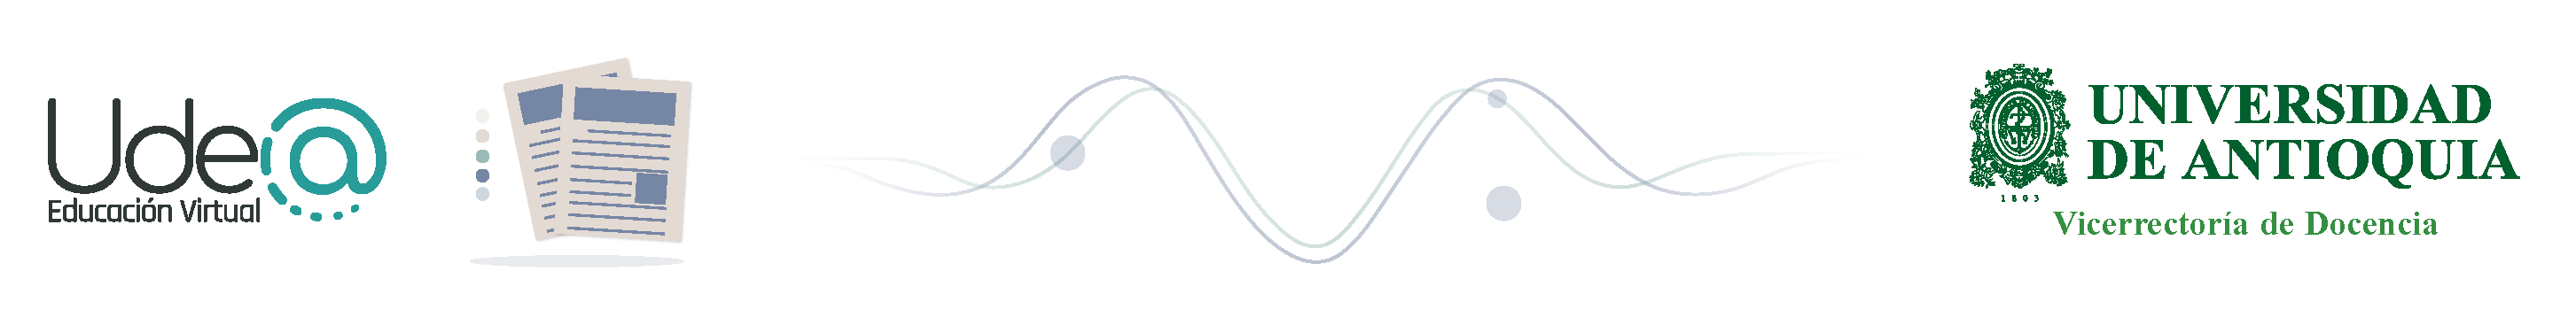

# Affective Computing Analysis


**Tratamiento de Señales III**

*Prof. Hernán Felipe García Arias*

*Facultad de Ingeniería*

*Universidad de Antioquia*

*2022-1*

Integrantes:
- Camilo Hernández Ruiz
- Yan Sebastian Hoyos Castaño


## 0. Cargar bases de datos de computación afectiva


La base de datos [DEAP](http://www.eecs.qmul.ac.uk/mmv/datasets/deap/index.html) es un conjunto de datos multimodal para el análisis de los estados afectivos humanos. El electroencefalograma (EEG) y las señales fisiológicas periféricas de 32 participantes se registraron mientras cada uno miraba 40 extractos de videos musicales de un minuto de duración. Los participantes calificaron cada video en términos de niveles de excitación (arousal), valencia, me gusta / no me gusta, dominio y familiaridad. Para 22 de los 32 participantes, también se grabó un video de cara frontal. Se utilizó un método novedoso para la selección de estímulos, utilizando la recuperación por etiquetas afectivas del sitio web last.fm, detección de videos destacados y una herramienta de evaluación en línea.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import seaborn as sns
import scipy.io as sio
from scipy import signal
import numpy as np
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ruta = '/content/drive/MyDrive/Tratamiento de Señales III/Mini-proyecto 1/datasets/'
fileName = 'affetiveDB_1.mat'
db = sio.loadmat(ruta+fileName)
display(db)

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Wed Aug 21 08:32:33 2013',
 '__version__': '1.0',
 'data': array([[[ 8.28494516e+00, -4.70161096e+00, -1.02672095e+01, ...,
          -9.77824286e+00, -3.02833644e+00,  9.30602221e+00],
         [-6.53134353e+00, -6.39228885e+00, -5.35397659e+00, ...,
          -9.64971643e+00,  3.38012568e+00,  3.81578354e+00],
         [-4.31897037e+00, -7.25473610e+00, -6.09319182e+00, ...,
           1.08196674e+00,  5.08426157e-02, -7.81959030e+00],
         ...,
         [-1.91385364e+03, -1.95304107e+03, -1.99285350e+03, ...,
          -5.04522286e+03, -5.08694153e+03, -5.09962900e+03],
         [-3.90420066e+03, -3.95498114e+03, -3.99746096e+03, ...,
           6.22601646e+03,  6.14984575e+03,  6.07367503e+03],
         [ 8.17697854e-04,  8.17697854e-04,  8.17697854e-04, ...,
           1.98174544e-02,  1.98174544e-02,  2.08174416e-02]],
 
        [[ 1.43362822e+01,  2.82370646e+01,  6.88048163e+00, ...,
  

### Dataset description

La base de datos se le removieron los 3 segundos iniciales de acondicionamiento. El arreglo X contiene todas las respuestas emocionales de las señales biológicas, para 40 videos diferentes. El arreglo se organiza de la forma:

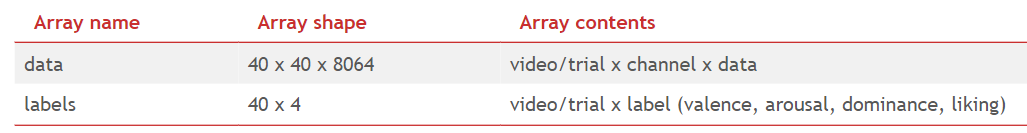

In [ ]:
X = db['data']
print(X.shape)
labels = db['labels']
print(X)

(40, 40, 6528)
[[[ 8.28494516e+00 -4.70161096e+00 -1.02672095e+01 ... -9.77824286e+00
   -3.02833644e+00  9.30602221e+00]
  [-6.53134353e+00 -6.39228885e+00 -5.35397659e+00 ... -9.64971643e+00
    3.38012568e+00  3.81578354e+00]
  [-4.31897037e+00 -7.25473610e+00 -6.09319182e+00 ...  1.08196674e+00
    5.08426157e-02 -7.81959030e+00]
  ...
  [-1.91385364e+03 -1.95304107e+03 -1.99285350e+03 ... -5.04522286e+03
   -5.08694153e+03 -5.09962900e+03]
  [-3.90420066e+03 -3.95498114e+03 -3.99746096e+03 ...  6.22601646e+03
    6.14984575e+03  6.07367503e+03]
  [ 8.17697854e-04  8.17697854e-04  8.17697854e-04 ...  1.98174544e-02
    1.98174544e-02  2.08174416e-02]]

 [[ 1.43362822e+01  2.82370646e+01  6.88048163e+00 ...  7.91290511e+00
    3.20571276e+01 -1.58442784e+01]
  [-1.76864183e+01  4.10948537e-01  2.68166599e+00 ...  1.00945216e+01
   -1.11365136e+01 -8.47526571e+00]
  [-1.72504726e+00 -6.63139871e+00 -4.13158563e+00 ... -3.42520062e+00
   -4.63019791e-01  5.43444232e+00]
  ...
  [-4.83

La siguiente tabla muestra el diseño de canales y el preprocesamiento realizado:

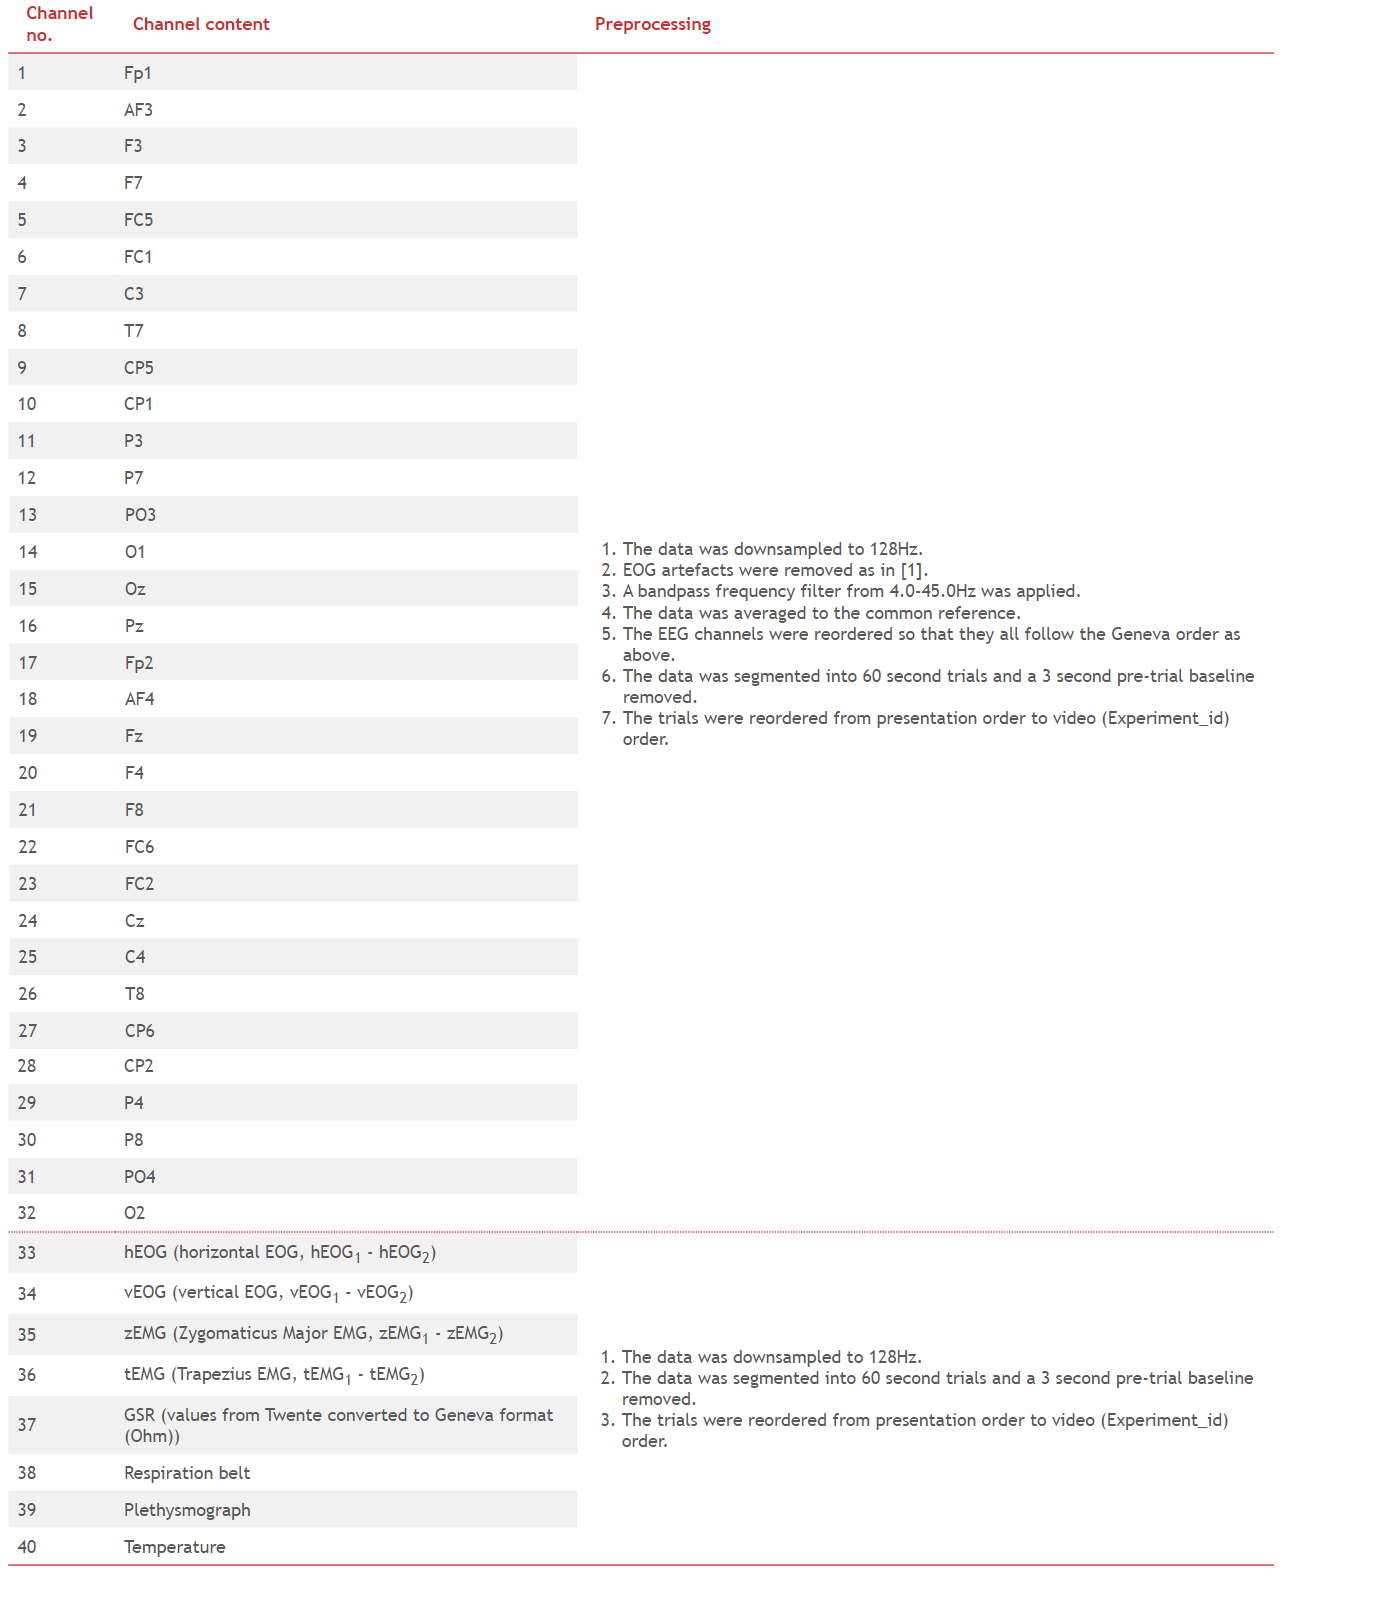

## Siglas señales fisiológicas

- EEG: señales electroencefalográficas, generalmente son 32 canales 

- EOG: electrooculograma (2 señales) movimientos verticales y horizontales

- EMG: electromiogramas (2 señales) para los movimientos de los músculos (en la base de datos se capturó la señal del rostro).

- Respiration belt:  banda que mide la frecuencia respiratoria

- Temperatura: Mide la temperatura de la piel

- Plethismograph:  Un pletismógrafo es un instrumento para medir cambios de volumen dentro de un órgano o de todo el cuerpo (generalmente como resultado de fluctuaciones en la cantidad de sangre o aire que contiene). Nos sirve como medida de el rítmo cardiaco (HR)

- GSR: La respuesta galvánica de la piel (GSR), también denominada actividad electrodérmica (EDA) y conductancia de la piel (SC), es la medida de las continuas variaciones en las características eléctricas de la piel, por ejemplo la conductancia, causada por la variación de la sudoración del cuerpo humano. La teoría tradicional del análisis de la respuesta galvánica de la piel está basada en la suposición de que la resistencia de la piel varía con el estado de las glándulas sudoríparas de la piel.
Read more at: https://www.brainsigns.com/es/science/s2/technologies/gsr
Copyright © BrainSigns

## Gráfica de una señal emocional

Por ejemplo si queremos obtener la señal de **GSR (galvanometría)** de la base de datos para el video número 15 (i.e., por elegir alguno), debe acceder a los datos mediante:

In [ ]:
N = 40 # observations per subject
nSignals = 40
Npoints = 6528
T = 1./128
print('Time duration (s):', Npoints*T )

Time duration (s): 51.0


(40, 6528)
51.0 s
51.0 s


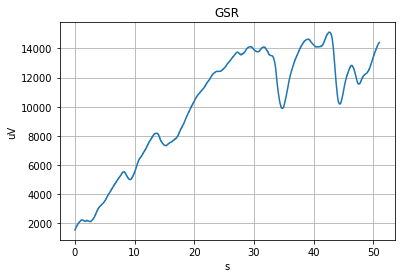

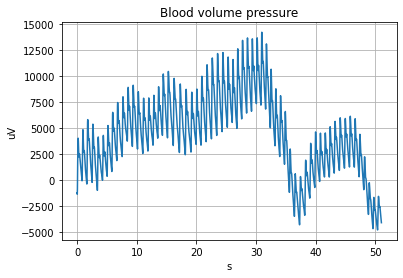

In [ ]:
trial = 15 # video una observación 
GSRchannel = 37 # canal de la señal GSR
GSR = X[:,GSRchannel-1,:]
print(GSR.shape)
ts = len(GSR[0,:])/128.
print(f'{ts} s')

BVPchannel = 39 # canal de señal de pletismografía/blood volume pressure
BVP = X[:,BVPchannel-1,:]
ts = len(BVP[0,:])/128.
print(f'{ts} s')

# Graficando la medida de GSR de un experimento
gsr=GSR[trial-1,:]
time = np.linspace(0,ts,len(gsr))
plt.plot(time,gsr)
plt.ylabel('uV')
plt.xlabel('s')
plt.title('GSR')
plt.grid()
plt.show()

# Graficando la medida de Pretismografía de un experimento
bvp=BVP[trial-1,:]
time = np.linspace(0,ts,len(bvp))
plt.plot(time,bvp)
plt.ylabel('uV')
plt.xlabel('s')
plt.title('Blood volume pressure')
plt.grid()
plt.show()

# 1. Extracción de características

Para extraer las características, se deben recorrer los 40 ejemplos, procesarlos y almacenar el resultado de cada uno como un elemento de una matriz $\boldsymbol{X_{new}} \in {\mathbb{R}}^{N \times D}$ donde $N=40$ realizaciones y $D=18$ mínimos descriptores.

In [ ]:
# Inicialización de la matriz de características y de la lista de títulos para el DataFrame
X_new = np.zeros((40,185))
descriptores = []

Se extraerán las siguientes características:

## 1.1 Resistencia Galvánica de la Piel (GSR)
### 1.1.1 Promedio de la resistencia de la piel

$Prom_{GSR} = \frac{1}{n} \sum_{n=0}^{39} GSR(t)$

In [ ]:
# Recorriendo los 40 experimentos
for i,gsr in enumerate(GSR):
  X_new[i,0] = gsr.mean()
else:
  # Añadir el nombre del descriptor a la lista de títulos para el DataFrame
  descriptores.append('Media GSR')

### 1.1.2 Promedio de la derivada

Promedio de la derivada:  361.5057316979247


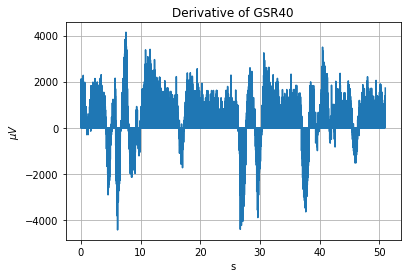

In [ ]:
for i, gsr in enumerate(GSR):
  gsrprime = np.gradient(gsr,T)
  X_new[i,1] = gsrprime.mean()
else:
  # Añadir el nombre del descriptor a la lista de títulos para el DataFrame
  descriptores.append('Media delta GSR')
  print('Promedio de la derivada: ', X_new[i,1])
  plt.figure(figsize=(6,4))
  plt.plot(time,gsrprime)
  plt.title(f'Derivative of GSR{i+1}')
  plt.xlabel('s')
  plt.ylabel('$\mu V$')
  plt.grid()
  plt.show()

### 1.1.3 Promedio de la derivada únicamente para valores negativos (decrecimiento promedio de la tasa durante el tiempo de decaimiento)

In [ ]:
for i, gsr in enumerate(GSR):
  gsrprime = np.gradient(gsr,T)
  X_new[i,2] = gsrprime[gsrprime<=0].mean()
  #print(X_new[i,2])
else:
  descriptores.append('Media delta negativa GSR')
  print(descriptores)
  #print(X_new)

['Media GSR', 'Media delta GSR', 'Media delta negativa GSR']


## 1.2 Volumen de la presión sanguínea (pletismografía)
### 1.2.1 Promedio y desviación estándar de HR

$Energy_{ratio} = \frac{Energy_{low-band}}{Energy_{medium-band}} $

In [ ]:
# Recorriendo los 40 experimentos
for i,bvp in enumerate(BVP):
  X_new[i,3] = bvp.mean()
  X_new[i,4] = bvp.std()
else:
  # Añadir el nombre del descriptor a la lista de títulos para el DataFrame
  descriptores.append('Media BVP')
  descriptores.append('Desviación Estándar BVP')

### 1.2.2 Razón de energía entre las bandas de frecuencia [0.04-0.15] Hz y [0.15-0.5] Hz



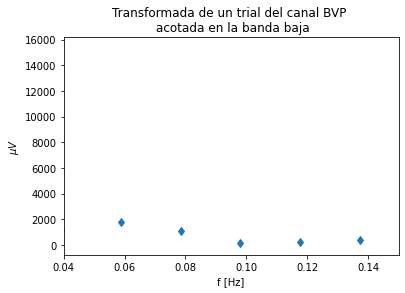

In [ ]:
# Graficando un ejemplo
from scipy.fft import fft, fftfreq
N=BVP.shape[1]
yf = np.abs( 2*fft(bvp)[:N//2]/N ) # Multiplicar por 2 porque la potencia está dividida por la simetría de la FFT
xf = fftfreq(N, T)[:N//2] # Creación del vector de frecuencias con N puntos y resolución T
plt.plot(xf, yf,'d')
plt.xlim(0.04,0.15)
plt.title('Transformada de un trial del canal BVP \n acotada en la banda baja')
plt.xlabel('f [Hz]')
plt.ylabel('$\mu V$')
plt.show()

In [ ]:
mask_low = (xf > 0.04) & (xf < 0.15)
mask_medium = (xf > 0.15) & (xf < 0.5)
# Recorriendo los 40 experimentos
for i,bvp in enumerate(BVP):
  yf = np.abs( fft(bvp)[:N//2]/N )
  X_new[i,5] = np.sum(yf[mask_low])/np.sum(yf[mask_medium])
else:
  # Añadir el nombre del descriptor a la lista de títulos para el DataFrame
  descriptores.append('Razón de energía BVP')

### 1.2.3 Potencia espectral en las bandas [0.1-0.2]Hz, [0.2-0.3]Hz, [0.3-0.4]Hz

$Power = max(|X(f_{band})|)$

In [ ]:
mask_low = (xf > 0.1) & (xf < 0.2)
mask_medium = (xf > 0.2) & (xf < 0.3)
mask_high = (xf > 0.3) & (xf < 0.4)
# Recorriendo los 40 experimentos
for i,bvp in enumerate(BVP):
  yf = np.abs( fft(bvp)[:N//2]/N )
  X_new[i,6] = np.max(yf[mask_low])
  X_new[i,7] = np.max(yf[mask_medium])
  X_new[i,8] = np.max(yf[mask_high])
else:
  # Añadir el nombre del descriptor a la lista de títulos para el DataFrame
  descriptores.append('Potencia espectral banda baja BVP')
  descriptores.append('Potencia espectral banda media BVP')
  descriptores.append('Potencia espectral banda alta BVP')

## 1.3 Patrón de respiración
Características extraídas:
- Desviación estándar
- Media
- Media de la derivada

In [ ]:
# Para la respiración
res_channel = 38 # canal de la señal fisiológica
respiration = X[:, res_channel-1, :]

for i,res in enumerate(respiration):
  X_new[i,9] = np.std(res) # Desviación estándar
  X_new[i,10] = np.mean(res) # Media
  X_new[i,11] = np.mean(np.gradient(res,T)) # Media de la derivada
else:
  descriptores.append('Desviación estándar Res Pattern')
  descriptores.append('Media Res Pattern')
  descriptores.append('Media derivada Res Pattern')

## 1.4 Patrón de temperatura
Características extraídas:

- Desviación estándar
- Media
- Media de la derivada
- Potencia absoluta en las bandas baja [0, 0.1] Hz y media [0.1, 0.2] Hz

In [ ]:
# Para la temperatura
temp_channel = 40 # canal de la señal fisiológica
temperature = X[:, temp_channel-1, :]

for i,temp in enumerate(temperature):
  X_new[i,12] = np.std(temp) # Desviación estándar
  X_new[i,13] = np.mean(temp) # Media
  X_new[i,14] = np.mean(np.gradient(temp,T)) # Media de la derivada
else:
  descriptores.append('Desviación estándar Temperature')
  descriptores.append('Media Temperature')
  descriptores.append('Media derivada Temperature')

xf = fftfreq(Npoints, T)[:Npoints//2]
mask_low = (xf > 0) & (xf < 0.1)
mask_medium = (xf > 0.1) & (xf < 0.2)

for trial in range(40):
  temperature = X[trial, temp_channel-1, :]
  yf = np.abs(fft(temperature)[:Npoints//2]/Npoints)
  X_new[trial,15] = np.sum(yf[mask_low])
  X_new[trial,16] = np.sum(yf[mask_medium])
else:
  descriptores.append('Energía banda baja Temperatura')
  descriptores.append('Energía banda media Temperatura')

## 1.5 Señales hEOG, vEOG, zEMG, tEMG
Características extraídas de cada una:
- Varianza
- Media

In [ ]:
channel = 33 # canal de la señal fisiológica

for trial in range(40):
  hEOG = X[trial, channel-1, :]

  X_new[trial,17] = np.var(hEOG)
  X_new[trial,18] = np.mean(hEOG)
else:
  descriptores.append('Varianza hEOG')
  descriptores.append('Media hEOG')

channel = 34 # canal de la señal fisiológica

for trial in range(40):
  vEOG = X[trial, channel-1, :]

  X_new[trial,19] = np.var(vEOG)
  X_new[trial,20] = np.mean(vEOG)
else:
  descriptores.append('Varianza vEOG')
  descriptores.append('Media vEOG')

channel = 35 # canal de la señal fisiológica

for trial in range(40):
  zEMG = X[trial, channel-1, :]

  X_new[trial,21] = np.var(zEMG)
  X_new[trial,22] = np.mean(zEMG)
else:
  descriptores.append('Varianza zEMG')
  descriptores.append('Media zEMG')

channel = 36 # canal de la señal fisiológica

for trial in range(40):
  tEMG = X[trial, channel-1, :]

  X_new[trial,23] = np.var(tEMG)
  X_new[trial,24] = np.mean(tEMG)
else:
  descriptores.append('Varianza tEMG')
  descriptores.append('Media tEMG')

## 1.6 Características de las señales EEG

En contextos clínicos, EEG se refiere a la grabación de la actividad eléctrica espontánea del cerebro durante un período de tiempo, registrados a partir de múltiples electrodos colocados en el cuero cabelludo. 

In [ ]:
# Recogiendo las señales electroencefalográficas en una matriz
EEGchannels = range(0,32)
EEG = X[:,EEGchannels,:]
print(EEG.shape)

(40, 32, 6528)


#### Bandas encefalográficas:
- Delta ⟷ [0.5, 3] Hz
- Theta ⟷ [4, 7] Hz
- Alpha ⟷ [8, 12] Hz
- Beta ⟷ [13, 30] Hz
- Gamma ⟷ [31, ∞) Hz

#### Propiedades espectrales
Para cada una de las señales en las bandas especificadas, se extraerá la densidad de potencia absoluta (μV2 / Hz). La potencia absoluta de una banda es la integral de todos los valores de potencia dentro de su rango de frecuencia.

#### Potencia Absoluta

$PotAbs = \sum_{n=1}^N{pot(X)_{n}}$

In [ ]:
delta_band = (xf > 0.5) & (xf < 3)
theta_band = (xf > 4) & (xf < 7)
alpha_band = (xf > 8) & (xf < 12)
beta_band = (xf >  13) & (xf < 30)
gamma_band = (xf > 31)

nombre_banda = ('Delta', 'Theta', 'Alpha', 'Beta', 'Gamma')
feature=25
for channel in range(EEG.shape[1]):
  for i,band in enumerate((delta_band, theta_band, alpha_band, beta_band, gamma_band)):
    for trial,eeg in enumerate(EEG[:,channel,:]):
      yfdb = 20*np.log(np.abs( 2*fft(eeg)[:N//2]/N ))
      X_new[trial,feature] = np.sum(yfdb[band])
      print(f'Canal: {channel}. Característica: {feature}. Experimento: {trial}.')
    else:
      feature+=1
      descriptores.append(f'Pot abs {nombre_banda[i]} EEG{channel+1}')

Se truncaron las últimas líneas 5000 del resultado de transmisión.
Canal: 7. Característica: 60. Experimento: 0.
Canal: 7. Característica: 60. Experimento: 1.
Canal: 7. Característica: 60. Experimento: 2.
Canal: 7. Característica: 60. Experimento: 3.
Canal: 7. Característica: 60. Experimento: 4.
Canal: 7. Característica: 60. Experimento: 5.
Canal: 7. Característica: 60. Experimento: 6.
Canal: 7. Característica: 60. Experimento: 7.
Canal: 7. Característica: 60. Experimento: 8.
Canal: 7. Característica: 60. Experimento: 9.
Canal: 7. Característica: 60. Experimento: 10.
Canal: 7. Característica: 60. Experimento: 11.
Canal: 7. Característica: 60. Experimento: 12.
Canal: 7. Característica: 60. Experimento: 13.
Canal: 7. Característica: 60. Experimento: 14.
Canal: 7. Característica: 60. Experimento: 15.
Canal: 7. Característica: 60. Experimento: 16.
Canal: 7. Característica: 60. Experimento: 17.
Canal: 7. Característica: 60. Experimento: 18.
Canal: 7. Característica: 60. Experimento: 19.
Can

## Etiquetas emocionales

Cada una de las realizaciones induce una emoción en los sujetos. Por lo tanto cada realización (de las 40) tiene sus correspondientes etiquetas de la forma  (valence, arousal, dominance, liking)

$labels$	es una matriz de $40 \times 4$ en la cual se organiza de la forma	$video/trial \times label $

- Valence:	The valence rating (float between 1 and 9).
- Arousal:	The arousal rating (float between 1 and 9).
- Dominance:	The dominance rating (float between 1 and 9).
- Liking:	The liking rating (float between 1 and 9).

Los modelos dimensionales sugieren que la emoción se entiende mejor cuando ocurre dentro de un espacio dimensional, más comúnmente un espacio bidimensional que abarca la valencia y la excitación. La valencia emocional describe el grado en que una emoción es positiva o negativa, mientras que la excitación se refiere a su intensidad, es decir, la fuerza del estado emocional asociado.

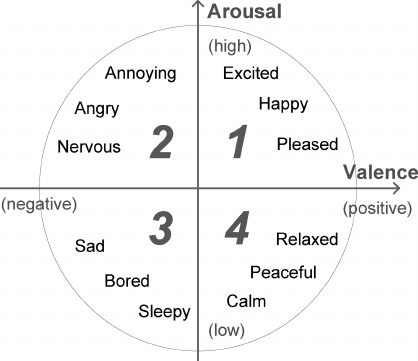

In [ ]:
print(labels)

[[2.51 5.65 2.9  1.97]
 [6.45 5.03 5.04 5.54]
 [6.74 5.83 6.37 6.83]
 [7.09 5.67 2.53 5.65]
 [5.51 7.9  9.   8.14]
 [4.99 3.63 5.05 2.78]
 [6.83 2.87 6.17 7.14]
 [3.51 2.88 7.14 1.5 ]
 [4.18 4.24 4.55 2.96]
 [5.14 7.5  9.   7.01]
 [7.27 4.27 5.04 3.15]
 [5.97 3.9  4.1  6.01]
 [3.88 2.14 1.42 2.54]
 [3.64 6.28 2.83 6.96]
 [2.67 5.53 1.   6.05]
 [4.97 1.   5.05 2.76]
 [1.21 8.47 1.19 9.  ]
 [6.56 5.72 5.22 7.37]
 [2.86 2.94 3.9  2.4 ]
 [3.82 5.87 7.63 1.87]
 [4.42 2.   6.22 2.62]
 [6.79 1.   5.03 4.36]
 [3.9  3.83 2.77 3.54]
 [2.51 5.38 1.53 5.99]
 [2.47 3.45 2.4  2.13]
 [1.82 6.21 3.36 7.56]
 [2.59 5.49 2.88 1.83]
 [2.85 3.38 3.44 6.69]
 [3.23 2.79 3.09 2.62]
 [6.1  3.68 3.88 6.05]
 [3.88 5.79 5.04 6.19]
 [5.01 8.12 4.96 2.86]
 [1.   3.92 4.96 1.  ]
 [1.   7.53 1.   1.  ]
 [1.   3.71 4.22 1.82]
 [5.05 3.83 6.17 5.88]
 [6.09 5.5  6.44 5.83]
 [4.27 6.26 7.94 6.53]
 [6.13 5.97 8.49 6.  ]
 [3.74 3.77 4.05 6.19]]


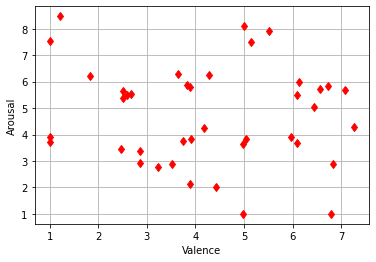

In [ ]:
Valence = labels[:,0]
Arousal = labels[:,1]

plt.plot(Valence,Arousal,'dr')
plt.grid()
plt.xlabel('Valence')
plt.ylabel('Arousal')
plt.show()

Por este laboratorio, sólo tendremos en cuenta la puntuación de Valence

In [ ]:
Valence

array([2.51, 6.45, 6.74, 7.09, 5.51, 4.99, 6.83, 3.51, 4.18, 5.14, 7.27,
       5.97, 3.88, 3.64, 2.67, 4.97, 1.21, 6.56, 2.86, 3.82, 4.42, 6.79,
       3.9 , 2.51, 2.47, 1.82, 2.59, 2.85, 3.23, 6.1 , 3.88, 5.01, 1.  ,
       1.  , 1.  , 5.05, 6.09, 4.27, 6.13, 3.74])

In [ ]:
Y_new = []
for i in Valence:
  if i>=1 and i<=3:
    Y_new.append('Negativo')
  elif i>3 and i<=6:
    Y_new.append('Neutral')
  elif i>6 and i<=9:
    Y_new.append('Positivo')
print(Y_new)

['Negativo', 'Positivo', 'Positivo', 'Positivo', 'Neutral', 'Neutral', 'Positivo', 'Neutral', 'Neutral', 'Neutral', 'Positivo', 'Neutral', 'Neutral', 'Neutral', 'Negativo', 'Neutral', 'Negativo', 'Positivo', 'Negativo', 'Neutral', 'Neutral', 'Positivo', 'Neutral', 'Negativo', 'Negativo', 'Negativo', 'Negativo', 'Negativo', 'Neutral', 'Positivo', 'Neutral', 'Neutral', 'Negativo', 'Negativo', 'Negativo', 'Neutral', 'Positivo', 'Neutral', 'Positivo', 'Neutral']


# 2. Modelo de visualización de pares característicos utilizando Seaborn

Lo primero es crear el DataFrame usando Pandas

In [ ]:
descriptores

['Media GSR',
 'Media delta GSR',
 'Media delta negativa GSR',
 'Media BVP',
 'Desviación Estándar BVP',
 'Razón de energía BVP',
 'Potencia espectral banda baja BVP',
 'Potencia espectral banda media BVP',
 'Potencia espectral banda alta BVP',
 'Desviación estándar Res Pattern',
 'Media Res Pattern',
 'Media derivada Res Pattern',
 'Desviación estándar Temperature',
 'Media Temperature',
 'Media derivada Temperature',
 'Energía banda baja Temperatura',
 'Energía banda media Temperatura',
 'Varianza hEOG',
 'Media hEOG',
 'Varianza vEOG',
 'Media vEOG',
 'Varianza zEMG',
 'Media zEMG',
 'Varianza tEMG',
 'Media tEMG',
 'Pot abs Delta EEG1',
 'Pot abs Theta EEG1',
 'Pot abs Alpha EEG1',
 'Pot abs Beta EEG1',
 'Pot abs Gamma EEG1',
 'Pot abs Delta EEG2',
 'Pot abs Theta EEG2',
 'Pot abs Alpha EEG2',
 'Pot abs Beta EEG2',
 'Pot abs Gamma EEG2',
 'Pot abs Delta EEG3',
 'Pot abs Theta EEG3',
 'Pot abs Alpha EEG3',
 'Pot abs Beta EEG3',
 'Pot abs Gamma EEG3',
 'Pot abs Delta EEG4',
 'Pot abs

In [ ]:
dF = pd.DataFrame(X_new,columns=descriptores)
dF.drop(columns='Desviación estándar Temperature',inplace=True) # Removemos una

#dF=(dF-dF.mean())/dF.std()


In [ ]:
num_columns = 23
subsets = 8*[0] # lista de sub-dataFrames
for i in range(len(subsets)):
  subsets[i] = dF.sample(n=num_columns,axis='columns')
  dF.drop(columns=subsets[i].columns,inplace=True)
  subsets[i].insert(0,'Valencia',Y_new)

In [ ]:
print(f'Tamaño de cada subset: {subsets[0].shape}','\n')
print(f'Cantidad de subsets: {len(subsets)}')

Tamaño de cada subset: (40, 24) 

Cantidad de subsets: 8


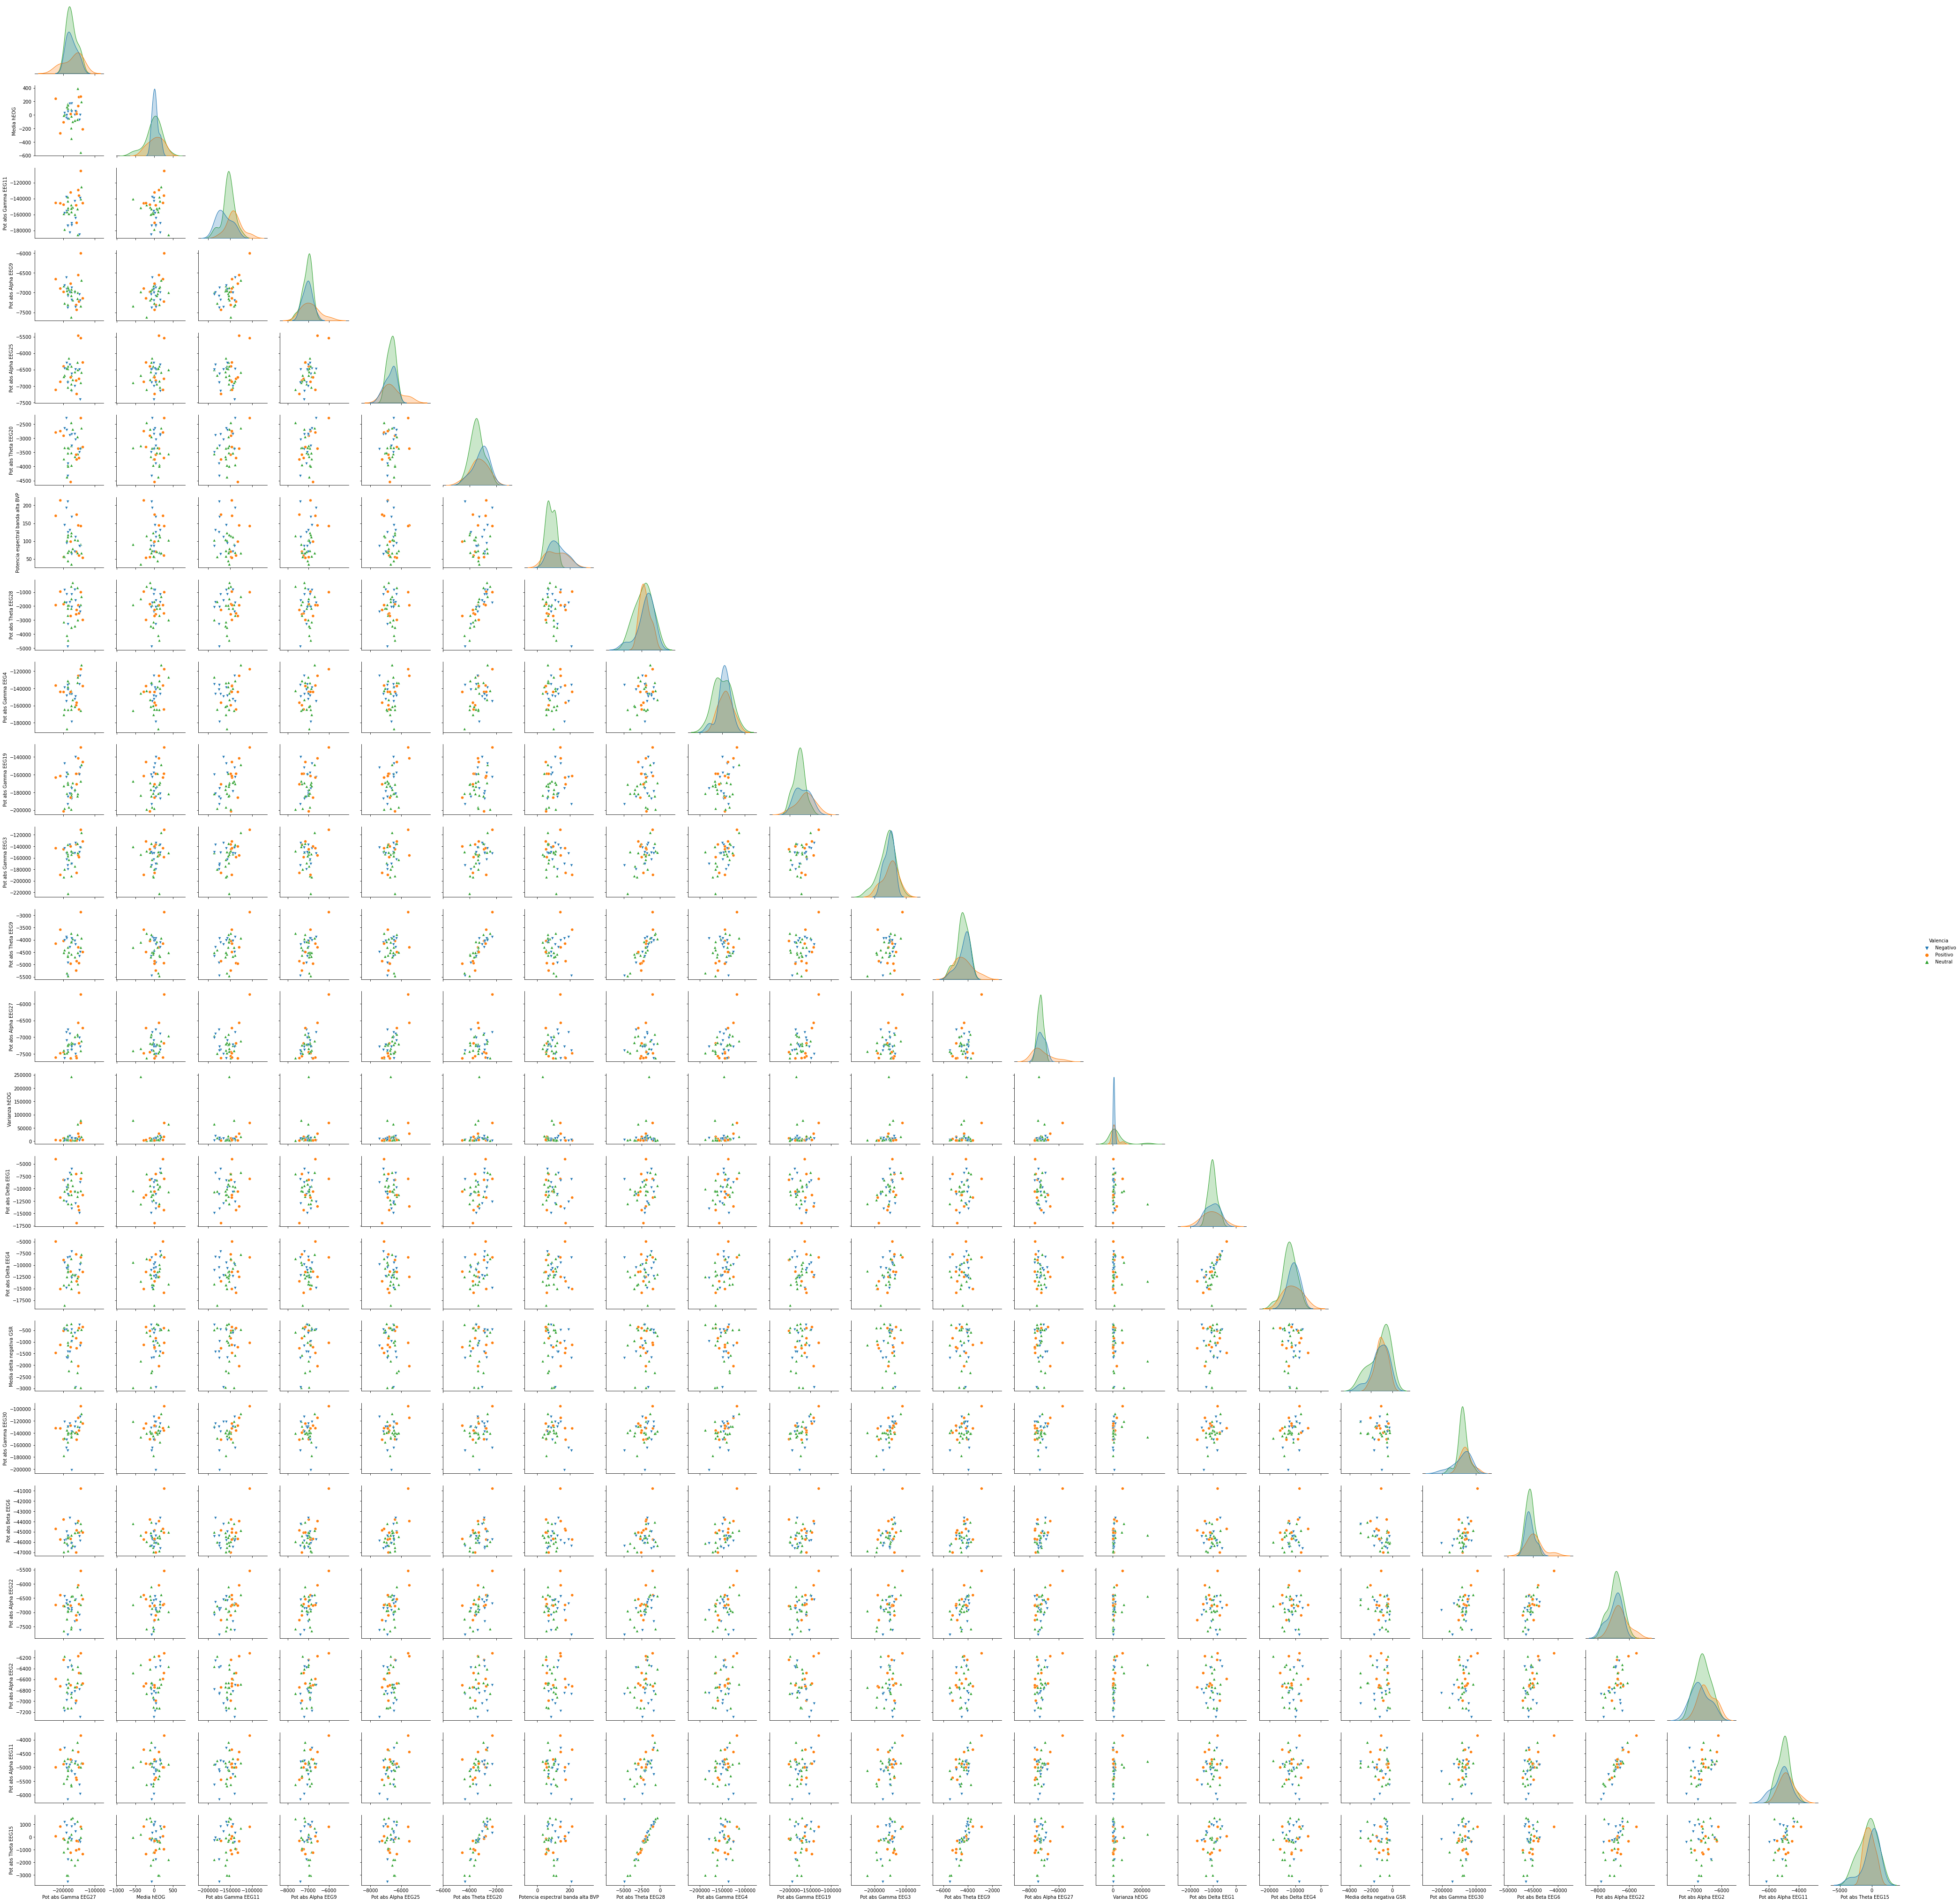

In [ ]:
# Pairplot Subset 0
sns.pairplot(subsets[0], hue="Valencia",corner = True, palette='tab10',markers=['v','o','^'])

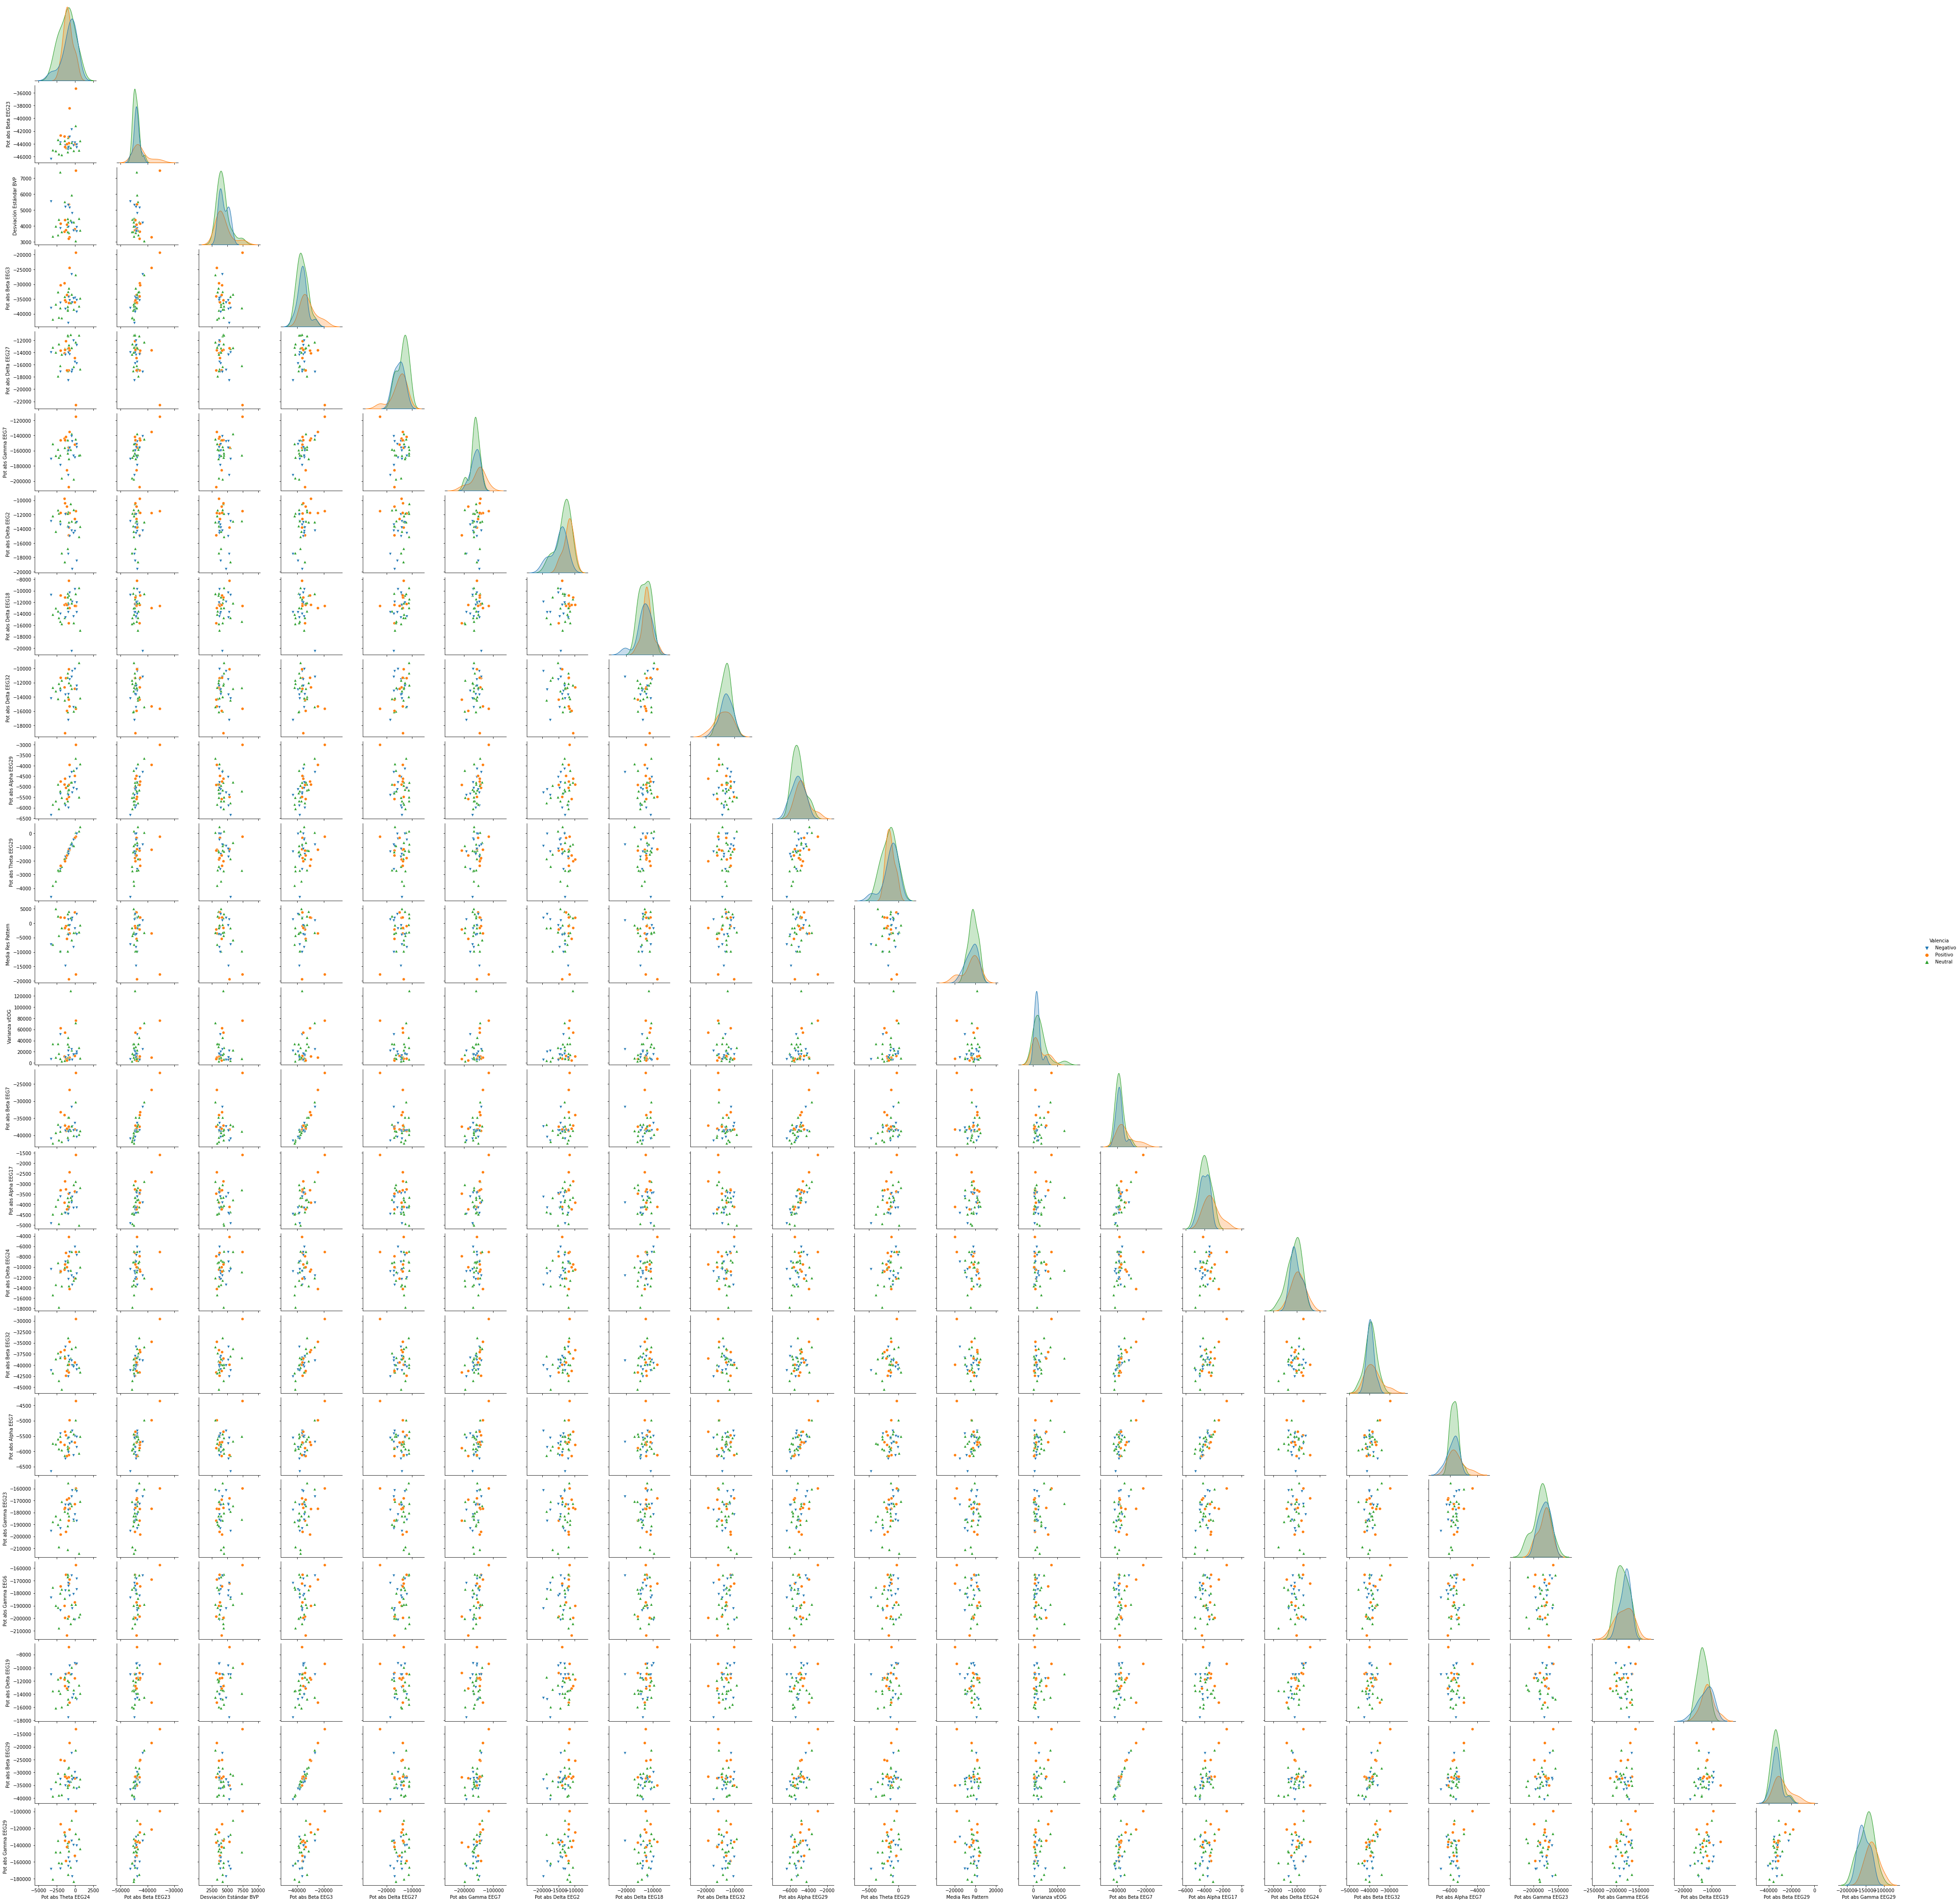

In [ ]:
# Pairplot Subset 1
sns.pairplot(subsets[1], hue="Valencia",corner = True, palette='tab10',markers=['v','o','^'])

In [ ]:
# Pairplot Subset 2
sns.pairplot(subsets[2], hue="Valencia",corner = True, palette='tab10',markers=['v','o','^'])

In [ ]:
# Pairplot Subset 3
sns.pairplot(subsets[3], hue="Valencia",corner = True, palette='tab10',markers=['v','o','^'])

In [ ]:
# Pairplot Subset 4
sns.pairplot(subsets[4], hue="Valencia",corner = True, palette='tab10',markers=['v','o','^'])

In [ ]:
# Pairplot Subset 5
sns.pairplot(subsets[5], hue="Valencia",corner = True, palette='tab10',markers=['v','o','^'])

In [ ]:
# Pairplot Subset 6
sns.pairplot(subsets[6], hue="Valencia",corner = True, palette='tab10',markers=['v','o','^'])

In [ ]:
# Pairplot Subset 7
sns.pairplot(subsets[7], hue="Valencia",corner = True, palette='tab10',markers=['v','o','^'])

# Discusión y Conclusiones:

* Se puede notar ante la gran cantidad de caracterisiticas obtenidas, que muchas de ellas estan correlacionadas y no se logra obetener buena información a partir de ellas para poder trabajar a la hora de subirlas como entradas, por ejemplo, a un algoritmo de machine learning.

* Entre las caracterisiticas halladas, se logra notar que hay varias que no tienen una correlación significativa entre ellas, con lo cuál se pueden seleccionar para la siguiente etapa del trabajo, que será introducirlos como entradas en una red neuronal, por ejemplo.

* Se pudo notar que al momento de manipular las señales del trabajo, se necesitaba hacer un preprocesamiento, en donde se trabajaba con las mismas de forma tal que se obtuvieran parametros que fueran representativos a la hora de generar las distintas caracteristicas que se usaron para la matriz de caracteristicas.

* En el presente proyecto, se contemplo como se procede a trabajar con un conjunto de señales después de ser obtenidas, en este caso, desde los electrodos conectados al cuerpo de varios participantes del ejercicio en cuestion; Al obtener las distintas señales necesarias, se procede a generar las caracteristicas a partir de transformaciones o demas información que se pueda obtener de ellas; Por ultimo se crea la matriz de caracteristicas a partir de toda la información obtenida previamente y con esto culmina el aprendizaje de esta primera parte del curso, para seguir avanzando con los demas temas interesantes del curso.